In [259]:
from lasy.profiles import CombinedLongitudinalTransverseProfile
from lasy.profiles.longitudinal import LongitudinalProfileFromData
from lasy.profiles.transverse import GaussianTransverseProfile
from lasy.laser import Laser
import numpy as np
import pandas as pd

In [260]:
input_params = {
    'kHz_Hexapod_Target ypos': 0,
    'kHz_Zaber_Compressor Position.Ch1': 50e3,
}

In [261]:
wavelength = 815e-9  # Laser wavelength in meters
pol = (1, 0)  # Linearly polarized in the x direction
laser_energy = 2e-3 # Energy of the laser pulse in joules
waist = 3.5e-6  # Waist of the laser pulse in meters
t_peak = 0.0  # Location of the peak of the laser pulse in time
focal_position = 200e-6 + input_params['kHz_Hexapod_Target ypos']*1e-3  # Focal position in meters
time_window_fs = 1000

dimensions = 'rt'  # Use cylindrical geometry
lo = (0,-time_window_fs/2*1e-15)        # Lower bounds of the simulation box
hi = (100e-6,time_window_fs/2*1e-15)  # Upper bounds of the simulation box
num_points = (1000, 6000)  # Number of points in each dimension

# Generate laser spectral intensity, including phase
df_specint = pd.read_csv('./retrieval01_spectrum.csv')

lambda_range = lambda_range = df_specint['Wavelength[nm]'].values * 1e-9
intensity = np.maximum( df_specint['Intensity[normalized]'].values, 0 ) # Make sure intensity is non-negative
phase = df_specint['Phase[rad]'].values


In [262]:
# Apply spectral phase from fused silica
lambda_micron = df_specint['Wavelength[nm]'].values * 1e-3
# Analytical formula from refractiveindex.info
n2 = 1 + 0.6961663 * lambda_micron**2 / (lambda_micron**2 - 0.0684043**2) \
        + 0.4079426 * lambda_micron**2 / (lambda_micron**2 - 0.1162414**2) \
        + 0.8974794 * lambda_micron**2 / (lambda_micron**2 - 9.896161**2)
n = n2**0.5
# Calculate the phase shift in radians
fused_silica_thickness_micron = 4e3 / 150e3 * ( input_params['kHz_Zaber_Compressor Position.Ch1'] - 75e3 )
# Subtract index of the mean wavelength, since this simply adds a constant delay
mean_wavelength = np.average( lambda_micron, weights=intensity )
n_central = n[ np.argmin( abs(lambda_micron-mean_wavelength) ) ]
phase_shift = 2 * np.pi * (n - n_central) / lambda_micron * fused_silica_thickness_micron

phase += phase_shift

In [263]:

# Create corresponding laser profile, by combining
# a longitudinal profile defined by the above spectral info
# and a transverse Gaussian profile
long_profile = LongitudinalProfileFromData(
    {'datatype': 'spectral',
        'axis': lambda_range,
        'intensity': intensity,
        'phase': phase,
        'dt': (hi[-1] - lo[-1]) / num_points[-1]},
    lo=lo[-1],
    hi=hi[-1])
# focal distance from calculation above (expressed via target z-position and projection due to angle of incidence)
trans_profile = GaussianTransverseProfile(waist, wavelength=wavelength, z_foc=d_foc_z)
laser_profile = CombinedLongitudinalTransverseProfile(wavelength, pol, laser_energy, long_profile, trans_profile)

# Define laser on a grid
laser = Laser(dimensions, lo, hi, num_points, laser_profile)
laser.propagate( -focal_position )

 56%|█████▌    | 00:05<00:04 [579.40it/s]


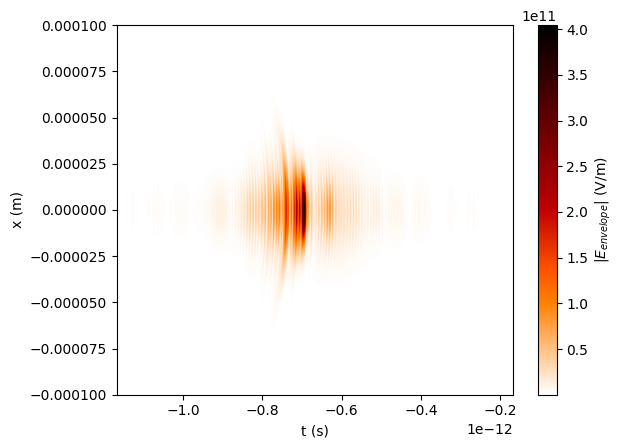

In [264]:
laser.show(cmap='gist_heat_r')

Text(0, 0.5, 'Phase [rad]')

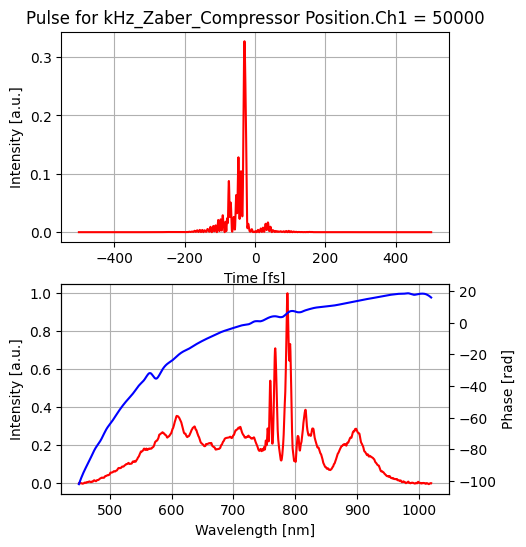

In [265]:
env = laser.grid.get_temporal_field()
t = np.linspace(-time_window_fs/2*1e-15, time_window_fs/2*1e-15, num_points[1])


plt.figure(figsize=(5, 6))

plt.subplot(211)
plt.plot( t*1e15, abs(env[0,0,:])**2/5e23, color='red' )
#plt.xlim(-100, 100)
plt.xlabel('Time [fs]')
plt.ylabel('Intensity [a.u.]')
#plt.ylim(0, 1)
plt.grid()
plt.title('Pulse for kHz_Zaber_Compressor Position.Ch1 = %d' %input_params['kHz_Zaber_Compressor Position.Ch1'])

plt.subplot(212)
plt.plot( df_specint['Wavelength[nm]'], df_specint['Intensity[normalized]'], color='red')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Intensity [a.u.]')
plt.grid()
plt.twinx()
plt.plot( df_specint['Wavelength[nm]'], df_specint['Phase[rad]'], color='blue')
plt.ylabel('Phase [rad]')